In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

In [7]:
### Functions ###

def Round_1(): # thi sfunction generates the first round of the game without grouping
   
    noise = np.random.uniform(1, 101, n_n).astype(int) # randomly generating n_n numbers for noise agents between 1 and 100
    noise_lbl = [["n"] * n_n][0] # labeling the noise agents as n
    
    lvl_1 = np.array([pi_vector[0] * 50] * n_1).astype(int) # generating n_1 numbers for level 1 agents based on the value of p vector
    lvl_1_lbl = [["one"] * n_1][0] # labeling the level 1 agents as one
    
    lvl_2 = np.array([pi_vector[0]**2 * 50] * n_2).astype(int) # generating n_2 numbers for level 2 agents based on the value of p vector
    lvl_2_lbl = [["two"] * n_2][0] # labeling the level 2 agents as two
    
    if level_noise == "y": # adding noise from normal distrbution to the level agents if parameter level_noise is "y"
        for i in range(0, len(lvl_1)):
            lvl_1[i] = lvl_1[i] + int(np.random.normal(0, dist_std, 1).item()) # dist_std is the std of distribution
            
        for j in range(0, len(lvl_2)):
            lvl_2[j] = lvl_2[j] + int(np.random.normal(0, dist_std, 1).item())

    df_n = pd.DataFrame({"id": range(1, n_n + 1), "Label": noise_lbl, "Round 1": noise})
    df_1 = pd.DataFrame({"id": range(n_n + 1, n_n + n_1 + 1), "Label": lvl_1_lbl, "Round 1": lvl_1})
    df_2 = pd.DataFrame({"id": range(n_n + n_1 + 1, n_n + n_1 + n_2 + 1), "Label": lvl_2_lbl, "Round 1": lvl_2})
    df = pd.concat([df_n, df_1, df_2]).reset_index(drop = True) 
    
    return df



def Cluster(data): # this function randomly puts agents in groups 
    
    sam_row = []
    cl = []
    for i in range(0, int(number_of_clusters)): # number of clusters is the group size
#       while size_of_clusters <= len(data):
        sam = data.sample(size_of_clusters)
        sam_index = sam.index.tolist()
        for j in sam_index:
            row = (sam.loc[j].iloc[0], sam.loc[j].iloc[1], sam.loc[j].iloc[-1])
            sam_row.append(row)
            
        cl.append(sam_row)
        data.drop(sam_index, 0, inplace = True)
        sam_row = []

#   if len(data) %% size_of_clusters =! 0: # check if size of data is not devidable to the cluster size
    data_index = data.index.tolist()
    for t in data_index:
        random_cl = np.random.randint(0, number_of_clusters, 1)[0]
        row_last = (data.loc[t].iloc[0], data.loc[t].iloc[1], data.loc[t].iloc[-1])
        cl[random_cl].append(row_last)    

    return cl




def Reward_Local(x, pi, mean):
    m = pi * mean
    reward = 5 - 0.05 * abs(x - m)
    
    return np.round(reward, 2)

def Rewards(cl, pi):
    rewards = []
    guess_1 = []
    
    for i in range(0, len(cl)):
        for j in cl[i]:
            guess_1.append(j[-1])
        g1_mean = np.mean(guess_1)
        for t in cl[i]:
            rew = Reward_Local(t[-1], pi, g1_mean)
            rewards.append(tuple([t[0], rew]))
        guess_1 = []
        
    return rewards



def Guess_Number(cl, pi):

    guess = []
    r_2 = []
    for i in range(0, len(cl)):
#        if noise_bounds == "y":
        for j in range(0, len(cl[i])):
            guess.append(cl[i][j][-1])
    
        cl_mean = np.mean(guess)
        min_cl = min(guess)
        max_cl = max(guess)

        for t in range(0, len(cl[i])):
            if cl[i][t][1] == "n":
                if noise_bounds == "y":
                    guess_2 = np.random.uniform(min_cl, max_cl + 1, 1).astype(int)[0]
                else:
                    guess_2 = np.random.uniform(1, 101, 1).astype(int)[0]
            elif cl[i][t][1] == "one":
                if level_noise == "y":
                    noise = int(np.random.normal(0, dist_std, 1).item())
                    guess_2 = int(np.round(pi * cl_mean + noise))
                else:
                    guess_2 = int(np.round(pi * cl_mean))
            else:
                if level_noise == "y":
                    noise = int(np.random.normal(0 , dist_std, 1).item())
                    guess_2 = int(np.round(pi**2 * cl_mean + noise))
                else:
                    guess_2 = int(np.round(pi**2 * cl_mean))
            
            if guess_2 > 100:
                guess_2 = 100
            if guess_2 < 1:
                guess_2 = 1

            r_2.append(tuple([cl[i][t][0], guess_2]))
    
        guess = []
    
    return r_2



def Game_Scenario_3(number_of_rounds):
    
    Round_1_tot = Round_1()
    Round_1_number = Round_1_tot.copy()

    df_number = Round_1_number.copy()
    df_number_fin = Round_1_number.copy()

    df_reward_fin = Round_1_number.copy().iloc[:, 1:2]
    df_reward_fin["Local Reward 1"] = [0] * N

    for r in range(2, number_of_rounds + 1):
        
        
        cluster_number = Cluster(df_number)
        g = Guess_Number(cluster_number, pi_vector[r-1])
        df_number_fin["Round {}".format(r)] = [0] * N
    
        rew = Rewards(cluster_number, pi_vector[r-2])
        df_reward_fin["Local Reward {}".format(r)] = [0] * N
    
        for i in range(0, N):
            df_number_fin["Round {}".format(r)].loc[g[i][0] - 1] = g[i][1]
            df_reward_fin["Local Reward {}".format(r-1)].loc[rew[i][0] - 1] = rew[i][1]

        df_number = df_number_fin.copy()
    
    cluster_number = Cluster(df_number)
    rew = Rewards(cluster_number, pi_vector[number_of_rounds-1])
    for i in range(0, N):
        df_reward_fin["Local Reward {}".format(number_of_rounds)].loc[rew[i][0] - 1] = rew[i][1]
    
    
    return df_number_fin, df_reward_fin, pi_vector



def Multiplyer(vector_number, number_of_rounds): # vector_number is the number of p vectors
    vec = [2/3, 4/3]     # multiplyers
    temp_pi_vector = []
    total_p = []
    np.random.seed(110) # fix seed for generating vectors of multiplyers
    for t in range(0, vector_number):
        for i in range(0, number_of_rounds):
            seed = np.random.randint(0, 2, 1).item()
            temp_pi_vector.append(vec[seed])
        total_p.append(temp_pi_vector)
        temp_pi_vector = []
    
    return total_p



def ClusterList(population):
    cluster_list =[]
    for i in range(2, int(population/2) + 1):
        if population % i == 0:
            cluster_list.append(i)

    return cluster_list

In [8]:
### Parameters ###

population = [100, 100, 1000, 1000, 10000, 10000]
n_n_vec = [30, 40, 300, 400, 3000, 4000]
n_1_vec = [50, 45, 500, 450, 5000, 4500]
n_2_vec = [20, 15, 200, 150, 2000, 1500]

dist_std = 2   # std of noises from normal distribution on level agents
noise_bounds = "y"  # whether noise agents choose numbers based on previous clusters or not (n)
number_of_rounds = 100  # number of round for each game
number_of_simulations = 10  # number of repetition of each game
vector_number = 10
total_p = Multiplyer(vector_number, number_of_rounds) # vector_number is the number of multiplyer vectors that each contains number of rounds P
level_noise = "y"
seeds = [123, 124, 125, 126, 127, 128]

In [9]:
### Simulation ###

Final_Numbers = []
Final_Rewards = []
cluster_list = []
for s in range(0, 6):
    N = population[s]
    n_n = n_n_vec[s]
    n_1 = n_1_vec[s]
    n_2 = n_2_vec[s]
    seed_number = seeds[s]
    
    c = ClusterList(N)
    cluster_list.append(c)  # cluster_list is required for getting the results in csv
    final_result_number = []
    final_resul_rewards = []
    np.random.seed(seed_number) # setting the seed number fro each scenario
    print("Scenario: ", s + 1)
    
    for p in range(0, len(total_p)):
    
        simulation_number = []
        simulation_reward = []
        fin = []
        tot_sim = [] # a list that contains arrays of simulations for each cluster size
        rew_sim = []
        pi_vector = total_p[p]
        print(" P Vector: ", p + 1)
    
        for i in c:
            print("  Group Size:", i)
    
            for j in range(0, number_of_simulations):
                if j == 0:
                    print("   Simulation Number:", j + 1)
                else:
                    print("                     ", j + 1)
                size_of_clusters = i
                number_of_clusters = int(N / size_of_clusters)

                test = Game_Scenario_3(number_of_rounds)
            
                if j == 0:
                    df_1 = test[0].iloc[:,1:]
                    df_2 = test[1]
                if j > 0:
                    df = pd.concat([df_1, test[0].iloc[:,1:]])
                    df_1 = df
                    df_rew = pd.concat([df_2, test[1]])
                    df_2 = df_rew

    
            df_1.reset_index(drop = True)
            sim_array = df_1.to_numpy()
            tot_sim.append(sim_array)
            df_2.reset_index(drop = True)
            rew_array = df_2.to_numpy()
            rew_sim.append(rew_array)
                                                          
        final_result_number.append(tot_sim)
        final_resul_rewards.append(rew_sim)
        
    
    Final_Numbers.append(final_result_number)
    Final_Rewards.append(final_resul_rewards)

Scenario:  1
 P Vector:  1
  Group Size: 2
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 4
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 5
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 10
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                 

                      6
                      7
                      8
                      9
                      10
  Group Size: 20
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 25
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 50
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
 P Vector:  6
  Group Size: 2
   Simulation Number: 1
                      2
                      3
   

                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 4
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 5
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 10
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Siz

                      8
                      9
                      10
  Group Size: 20
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 25
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 50
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
 P Vector:  5
  Group Size: 2
   Simulation Number: 1
                      2
                      3
                      4
                      5
   

                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 4
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 5
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 10
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 20
   Simulation Numb

                      10
  Group Size: 10
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 20
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 25
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 40
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                

                      7
                      8
                      9
                      10
  Group Size: 50
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 100
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 125
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 200
   Simulation Number: 1
                      2
                      3
                      4
             

                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 250
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 500
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
 P Vector:  7
  Group Size: 2
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 4
  

                      10
  Group Size: 4
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 5
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 8
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 10
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                   

                      6
                      7
                      8
                      9
                      10
  Group Size: 20
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 25
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 40
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 50
   Simulation Number: 1
                      2
                      3
                

                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 100
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 125
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 200
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 250
   Simulatio

                      10
  Group Size: 250
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 500
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
 P Vector:  6
  Group Size: 2
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 4
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
  

                      6
                      7
                      8
                      9
                      10
  Group Size: 5
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 8
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 10
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 20
   Simulation Number: 1
                      2
                      3
                  

                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 25
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 40
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 50
   Simulation Number: 1
                      2
                      3
                      4
                      5
                      6
                      7
                      8
                      9
                      10
  Group Size: 100
   Simulation N

KeyboardInterrupt: 

In [15]:
### Saving the Results ###
'''
for s in range(0, 6): # we have 6 scenarios
    for l in range(0, len(total_p)):
        for i in range(0, len(cluster_list[s])):
            pd.DataFrame(Final_Numbers[s][l][i]).to_csv(r'Address\Number_S{}_P{}_cluster_{}.csv'.format(s + 1, l + 1, cluster_list[s][i]))
            pd.DataFrame(Final_Rewards[s][l][i]).to_csv(r'Address\Reward_S{}_P{}_cluster_{}.csv'.format(s + 1, l + 1, cluster_list[s][i]))    
'''


In [8]:
#############################
### Analyzing the Results ###
#############################

'\ncluster_label = ["2", "4", "5", "8", "10", "16", "20", "25", "40", "50", "80", "100", "125", "200",\n                 "250", "400", "500", "625", "1000", "1250", "2000", "2500", "5000"]\nplt.figure(3, figsize=(12, 8), dpi=80)\nplt.plot(cluster_label, Total_mean_rewards[4], marker = "o", color = "darkgreen", linestyle = "--")\nplt.plot(cluster_label, Total_mean_rewards[5], marker = "o", color = "darkorange")\nplt.ylabel("Average Rewards", fontweight="bold")\nplt.xlabel("Group Size", fontweight="bold")\nplt.legend(["Scenario 5", "Scenario 6"])\nplt.grid(linestyle=\'-\')\n'

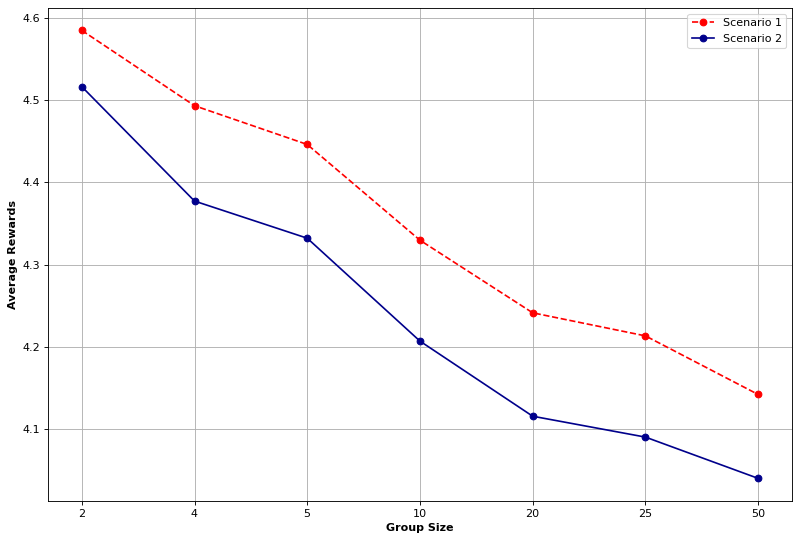

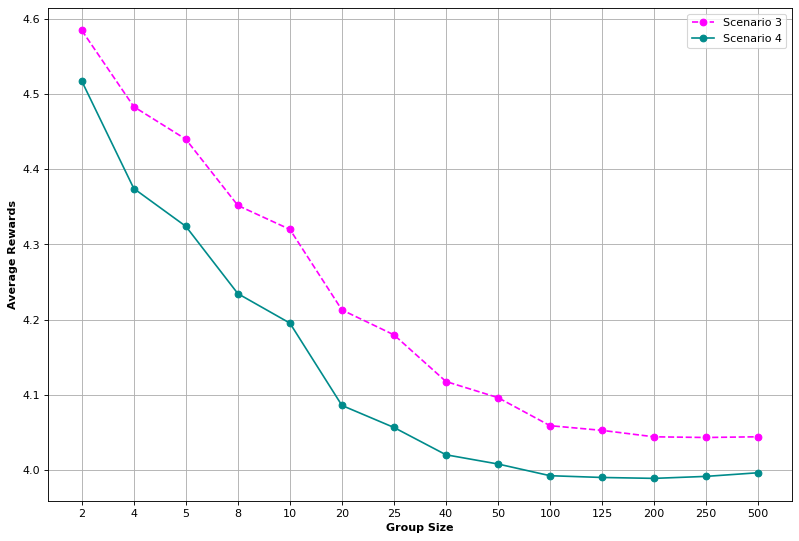

In [57]:
### Comparing Total Means in each poplulation between different group sizes ###

# cluster_size = [2, 4, 5, 10, 20, 25, 50]
# cluster_label = ["2", "4", "5", "10", "20", "25", "50"]
l = vector_number     ## l is the number of p vectors
pvector = list(range(0, l))

## Importing Rewards and Numbers Scenario 1 and 2
data = []
TM_RE = []  # divided based on number of scenarios
Total_mean_rewards = []

for s in range(0, 4):
    for j in range(0, len(cluster_list[s])):    
        for i in pvector:
            
            data.append(Final_Rewards[s][i][j][:,1:].mean()) ## this is the total mean of rewards
        TM_RE.append(sum(data) / l) # to calculate the means of each group size by different p vectors
        data = []
    Total_mean_rewards.append(TM_RE)
    TM_RE = []

cluster_label = ["2", "4", "5", "10", "20", "25", "50"]
plt.figure(1, figsize=(12, 8), dpi=80)
plt.plot(cluster_label, Total_mean_rewards[0], marker = "o", color = "red", linestyle = "--")
plt.plot(cluster_label, Total_mean_rewards[1], marker = "o", color = "darkblue")
plt.ylabel("Average Rewards", fontweight="bold")
plt.xlabel("Group Size", fontweight="bold")
plt.legend(["Scenario 1", "Scenario 2"])
plt.grid(linestyle='-')

cluster_label = ["2", "4", "5", "8", "10", "20", "25", "40", "50", "100", "125", "200", "250", "500"]
plt.figure(2, figsize=(12, 8), dpi=80)
plt.plot(cluster_label, Total_mean_rewards[2], marker = "o", color = "magenta", linestyle = "--")
plt.plot(cluster_label, Total_mean_rewards[3], marker = "o", color = "darkcyan")
plt.ylabel("Average Rewards", fontweight="bold")
plt.xlabel("Group Size", fontweight="bold")
plt.legend(["Scenario 3", "Scenario 4"])
plt.grid(linestyle='-')

'''
cluster_label = ["2", "4", "5", "8", "10", "16", "20", "25", "40", "50", "80", "100", "125", "200",
                 "250", "400", "500", "625", "1000", "1250", "2000", "2500", "5000"]
plt.figure(3, figsize=(12, 8), dpi=80)
plt.plot(cluster_label, Total_mean_rewards[4], marker = "o", color = "darkgreen", linestyle = "--")
plt.plot(cluster_label, Total_mean_rewards[5], marker = "o", color = "darkorange")
plt.ylabel("Average Rewards", fontweight="bold")
plt.xlabel("Group Size", fontweight="bold")
plt.legend(["Scenario 5", "Scenario 6"])
plt.grid(linestyle='-')
'''


'\n## Path graph - scenario 5 ## \nplt.figure(8, figsize=(12, 8), dpi=80)\nplt.plot(np.asarray(cluster5_2[:,1:].mean(axis = 0)), label = "2", color = "darkblue", linestyle = "--")\nplt.plot(np.asarray(cluster5_10[:,1:].mean(axis = 0)), label = "10", color = "crimson", linestyle = "--")\nplt.plot(np.asarray(cluster5_50[:,1:].mean(axis = 0)), label = "50", color = "limegreen", linestyle = "--")\nplt.plot(np.asarray(cluster5_100[:,1:].mean(axis = 0)), label = "100", color = "darkorange", linestyle = "--")\nplt.plot(np.asarray(cluster5_200[:,1:].mean(axis = 0)), label = "200", color = "darkcyan", linestyle = "--")\nplt.plot(np.asarray(cluster5_500[:,1:].mean(axis = 0)), label = "500", color = "red", linestyle = "--")\nplt.plot(np.asarray(cluster5_1250[:,1:].mean(axis = 0)), label = "1250", color = "violet", linestyle = "--")\nplt.plot(np.asarray(cluster5_2500[:,1:].mean(axis = 0)), label = "2500", color = "dimgray", linestyle = "--")\nplt.plot(np.asarray(cluster5_5000[:,1:].mean(axis = 0))

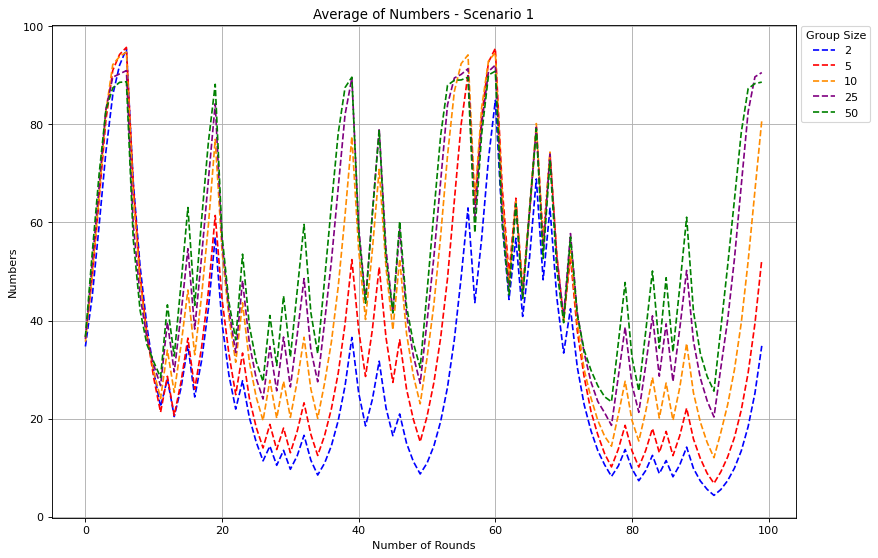

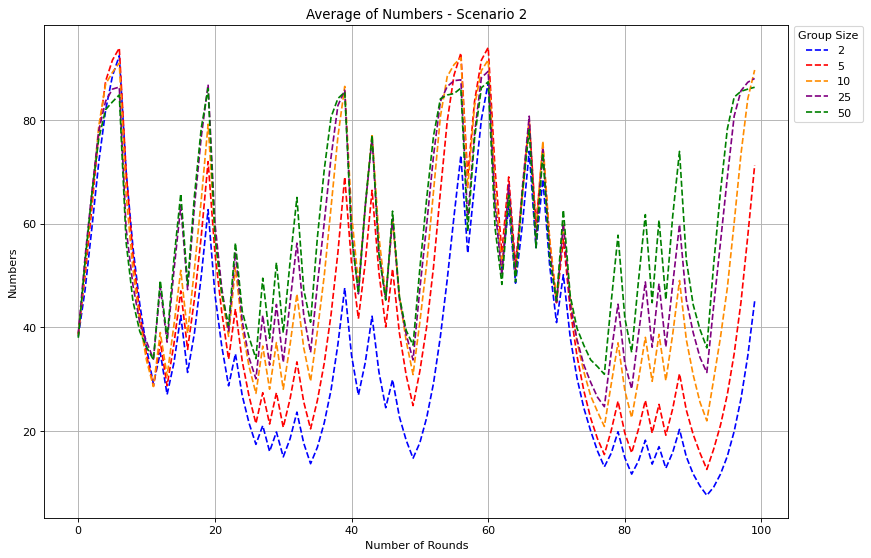

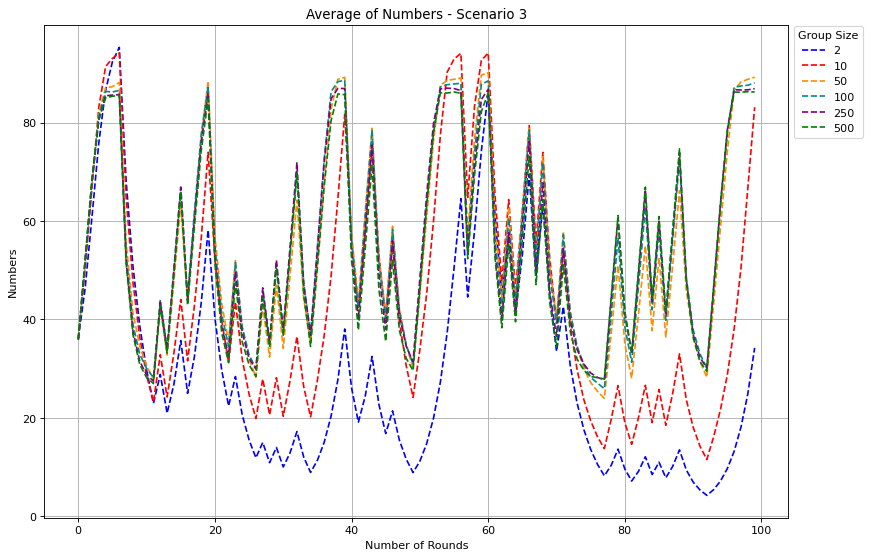

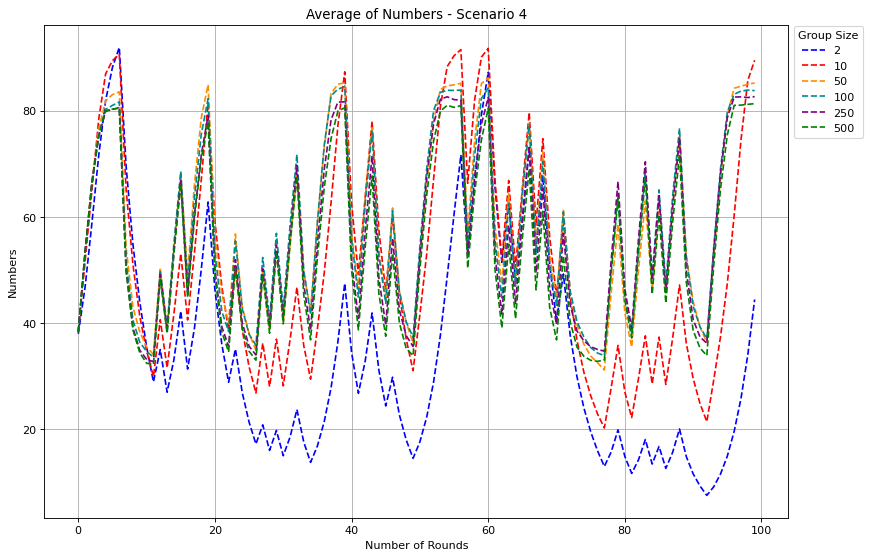

In [43]:
### Illustration of numbers' path for different group sizes in 100 rounds of each scenario ###

cluster1_2 = Final_Numbers[0][0][0]   #  Scenario 1, p vector 1, cluster 1 = group size 2
cluster1_5 = Final_Numbers[0][0][2]
cluster1_10 = Final_Numbers[0][0][3]
cluster1_25 = Final_Numbers[0][0][5]
cluster1_50 = Final_Numbers[0][0][6]

cluster2_2 = Final_Numbers[1][0][0]
cluster2_5 = Final_Numbers[1][0][2]
cluster2_10 = Final_Numbers[1][0][3]
cluster2_25 = Final_Numbers[1][0][5]
cluster2_50 = Final_Numbers[1][0][6]

cluster3_2 = Final_Numbers[2][0][0]
cluster3_10 = Final_Numbers[2][0][4]
cluster3_50 = Final_Numbers[2][0][8]
cluster3_100 = Final_Numbers[2][0][9]
cluster3_250 = Final_Numbers[2][0][12]
cluster3_500 = Final_Numbers[2][0][13]

cluster4_2 = Final_Numbers[3][0][0]
cluster4_10 = Final_Numbers[3][0][4]
cluster4_50 = Final_Numbers[3][0][8]
cluster4_100 = Final_Numbers[3][0][9]
cluster4_250 = Final_Numbers[3][0][12]
cluster4_500 = Final_Numbers[3][0][13]

'''
cluster5_2 = Final_Numbers[4][0][0]
cluster5_10 = Final_Numbers[4][0][4]
cluster5_50 = Final_Numbers[4][0][9]
cluster5_100 = Final_Numbers[4][0][11]
cluster5_200 = Final_Numbers[4][0][13]
cluster5_500 = Final_Numbers[4][0][16]
cluster5_1250 = Final_Numbers[4][0][19]
cluster5_2500 = Final_Numbers[4][0][21]
cluster5_5000 = Final_Numbers[4][0][22]

cluster6_2 = Final_Numbers[5][0][0]
cluster6_10 = Final_Numbers[5][0][4]
cluster6_50 = Final_Numbers[5][0][9]
cluster6_100 = Final_Numbers[5][0][11]
cluster6_200 = Final_Numbers[5][0][13]
cluster6_500 = Final_Numbers[5][0][16]
cluster6_1250 = Final_Numbers[5][0][19]
cluster6_2500 = Final_Numbers[5][0][21]
cluster6_5000 = Final_Numbers[5][0][22]
'''


for i in range(1, vector_number): ## 

    temp = cluster1_2.tolist().append(Final_Numbers[0][i][0])
    cluster1_2 = np.array(cluster1_2)
    
    temp = cluster1_5.tolist().append(Final_Numbers[0][i][2])
    cluster1_5 = np.array(cluster1_5)
    
    temp = cluster1_10.tolist().append(Final_Numbers[0][i][3])
    cluster1_10 = np.array(cluster1_10)
    
    temp = cluster1_25.tolist().append(Final_Numbers[0][i][5])
    cluster1_25 = np.array(cluster1_25)
    
    temp = cluster1_50.tolist().append(Final_Numbers[0][i][6])
    cluster1_50 = np.array(cluster1_50) 
    
    temp = cluster2_2.tolist().append(Final_Numbers[1][i][0])
    cluster2_2 = np.array(cluster2_2)
    
    temp = cluster2_5.tolist().append(Final_Numbers[1][i][2])
    cluster2_5 = np.array(cluster2_5)
    
    temp = cluster2_10.tolist().append(Final_Numbers[1][i][3])
    cluster2_10 = np.array(cluster2_10)
    
    temp = cluster2_25.tolist().append(Final_Numbers[1][i][5])
    cluster2_25 = np.array(cluster2_25)
    
    temp = cluster2_50.tolist().append(Final_Numbers[1][i][6])
    cluster2_50 = np.array(cluster2_50)
    
    
    temp= cluster3_2.tolist().append(Final_Numbers[2][i][0])
    cluster3_2 = np.array(cluster3_2)
    
    temp = cluster3_10.tolist().append(Final_Numbers[2][i][4])
    cluster3_10 = np.array(cluster3_10)
    
    temp = cluster3_50.tolist().append(Final_Numbers[2][i][8])
    cluster3_50 = np.array(cluster3_50)
    
    temp = cluster3_100.tolist().append(Final_Numbers[2][i][9])
    cluster3_100 = np.array(cluster3_100)
    
    temp = cluster3_250.tolist().append(Final_Numbers[2][i][12])
    cluster3_250 = np.array(cluster3_250)
    
    temp = cluster3_500.tolist().append(Final_Numbers[2][i][13])
    cluster3_500 = np.array(cluster3_500)
    
    temp = cluster4_2.tolist().append(Final_Numbers[3][i][0])
    cluster4_2 = np.array(cluster4_2)
    
    temp = cluster4_10.tolist().append(Final_Numbers[3][i][4])
    cluster4_10 = np.array(cluster4_10)
    
    temp = cluster4_50.tolist().append(Final_Numbers[3][i][8])
    cluster4_50 = np.array(cluster4_50)
    
    temp = cluster4_100.tolist().append(Final_Numbers[3][i][9])
    cluster4_100 = np.array(cluster4_100)
    
    temp = cluster4_250.tolist().append(Final_Numbers[3][i][12])
    cluster4_250 = np.array(cluster4_250)
    
    temp = cluster4_500.tolist().append(Final_Numbers[3][i][13])
    cluster4_500 = np.array(cluster4_500)
    
    '''
    cluster5_2 = cluster5_2.tolist().append(Final_Numbers[4][i][0])
    cluster5_10 = cluster5_10.tolist().append(Final_Numbers[4][i][4])
    cluster5_50 = cluster5_50.tolist().append(Final_Numbers[4][i][9])
    cluster5_100 = cluster5_100.tolist().append(Final_Numbers[4][i][11])
    cluster5_200 = cluster5_200.tolist().append(Final_Numbers[4][i][13])
    cluster5_500 = cluster5_500.tolist().append(Final_Numbers[4][i][16])
    cluster5_1250 = cluster5_1250.tolist().append(Final_Numbers[4][i][19])
    cluster5_2500 = cluster5_2500.tolist().append(Final_Numbers[4][i][21])
    cluster5_5000 = cluster5_5000.tolist().append(Final_Numbers[4][i][22])
    
    cluster6_2 = cluster6_2.tolist().append(Final_Numbers[5][i][0])
    cluster6_10 = cluster6_10.tolist().append(Final_Numbers[5][i][4])
    cluster6_50 = cluster6_50.tolist().append(Final_Numbers[5][i][9])
    cluster6_100 = cluster6_100.tolist().append(Final_Numbers[5][i][11])
    cluster6_200 = cluster6_200.tolist().append(Final_Numbers[5][i][13])
    cluster6_500 = cluster6_500.tolist().append(Final_Numbers[5][i][16])
    cluster6_1250 = cluster6_1250.tolist().append(Final_Numbers[5][i][19])
    cluster6_2500 = cluster6_2500.tolist().append(Final_Numbers[5][i][21])
    cluster6_5000 = cluster6_5000.tolist().append(Final_Numbers[5][i][22])
    '''
    

    
    
    
## Path graph - scenario 1 ##  
plt.figure(4, figsize=(12, 8), dpi=80)
plt.plot(np.asarray(cluster1_2[:,1:].mean(axis = 0)), label = "2", color = "blue", linestyle = "--")
plt.plot(np.asarray(cluster1_5[:,1:].mean(axis = 0)), label = "5", color = "red", linestyle = "--")
plt.plot(np.asarray(cluster1_10[:,1:].mean(axis = 0)), label = "10", color = "darkorange", linestyle = "--")
plt.plot(np.asarray(cluster1_25[:,1:].mean(axis = 0)), label = "25", color = "purple", linestyle = "--")
plt.plot(np.asarray(cluster1_50[:,1:].mean(axis = 0)), label = "50", color = "green", linestyle = "--")
plt.grid(linestyle='-')
plt.legend(title = "Group Size", bbox_to_anchor=(1, 1.01), loc='upper left')
plt.title("Average of Numbers - Scenario 1")
plt.xlabel("Number of Rounds")
plt.ylabel("Numbers")

## Path graph - scenario 2 ## 
plt.figure(5, figsize=(12, 8), dpi=80)
plt.plot(np.asarray(cluster2_2[:,1:].mean(axis = 0)), label = "2", color = "blue", linestyle = "--")
plt.plot(np.asarray(cluster2_5[:,1:].mean(axis = 0)), label = "5", color = "red", linestyle = "--")
plt.plot(np.asarray(cluster2_10[:,1:].mean(axis = 0)), label = "10", color = "darkorange", linestyle = "--")
plt.plot(np.asarray(cluster2_25[:,1:].mean(axis = 0)), label = "25", color = "purple", linestyle = "--")
plt.plot(np.asarray(cluster2_50[:,1:].mean(axis = 0)), label = "50", color = "green", linestyle = "--")
plt.grid(linestyle='-')
plt.legend(title = "Group Size", bbox_to_anchor=(1, 1.01), loc='upper left')
plt.title("Average of Numbers - Scenario 2")
plt.xlabel("Number of Rounds")
plt.ylabel("Numbers")

## Path graph - scenario 3 ## 
plt.figure(6, figsize=(12, 8), dpi=80)
plt.plot(np.asarray(cluster3_2[:,1:].mean(axis = 0)), label = "2", color = "blue", linestyle = "--")
plt.plot(np.asarray(cluster3_10[:,1:].mean(axis = 0)), label = "10", color = "red", linestyle = "--")
plt.plot(np.asarray(cluster3_50[:,1:].mean(axis = 0)), label = "50", color = "darkorange", linestyle = "--")
plt.plot(np.asarray(cluster3_100[:,1:].mean(axis = 0)), label = "100", color = "darkcyan", linestyle = "--")
plt.plot(np.asarray(cluster3_250[:,1:].mean(axis = 0)), label = "250", color = "purple", linestyle = "--")
plt.plot(np.asarray(cluster3_500[:,1:].mean(axis = 0)), label = "500", color = "green", linestyle = "--")
plt.grid(linestyle='-')
plt.legend(title = "Group Size", bbox_to_anchor=(1, 1.01), loc='upper left')
plt.title("Average of Numbers - Scenario 3")
plt.xlabel("Number of Rounds")
plt.ylabel("Numbers")


## Path graph - scenario 4 ## 
plt.figure(7, figsize=(12, 8), dpi=80)
plt.plot(np.asarray(cluster4_2[:,1:].mean(axis = 0)), label = "2", color = "blue", linestyle = "--")
plt.plot(np.asarray(cluster4_10[:,1:].mean(axis = 0)), label = "10", color = "red", linestyle = "--")
plt.plot(np.asarray(cluster4_50[:,1:].mean(axis = 0)), label = "50", color = "darkorange", linestyle = "--")
plt.plot(np.asarray(cluster4_100[:,1:].mean(axis = 0)), label = "100", color = "darkcyan", linestyle = "--")
plt.plot(np.asarray(cluster4_250[:,1:].mean(axis = 0)), label = "250", color = "purple", linestyle = "--")
plt.plot(np.asarray(cluster4_500[:,1:].mean(axis = 0)), label = "500", color = "green", linestyle = "--")
plt.grid(linestyle='-')
plt.legend(title = "Group Size", bbox_to_anchor=(1, 1.01), loc='upper left')
plt.title("Average of Numbers - Scenario 4")
plt.xlabel("Number of Rounds")
plt.ylabel("Numbers")

'''
## Path graph - scenario 5 ## 
plt.figure(8, figsize=(12, 8), dpi=80)
plt.plot(np.asarray(cluster5_2[:,1:].mean(axis = 0)), label = "2", color = "darkblue", linestyle = "--")
plt.plot(np.asarray(cluster5_10[:,1:].mean(axis = 0)), label = "10", color = "crimson", linestyle = "--")
plt.plot(np.asarray(cluster5_50[:,1:].mean(axis = 0)), label = "50", color = "limegreen", linestyle = "--")
plt.plot(np.asarray(cluster5_100[:,1:].mean(axis = 0)), label = "100", color = "darkorange", linestyle = "--")
plt.plot(np.asarray(cluster5_200[:,1:].mean(axis = 0)), label = "200", color = "darkcyan", linestyle = "--")
plt.plot(np.asarray(cluster5_500[:,1:].mean(axis = 0)), label = "500", color = "red", linestyle = "--")
plt.plot(np.asarray(cluster5_1250[:,1:].mean(axis = 0)), label = "1250", color = "violet", linestyle = "--")
plt.plot(np.asarray(cluster5_2500[:,1:].mean(axis = 0)), label = "2500", color = "dimgray", linestyle = "--")
plt.plot(np.asarray(cluster5_5000[:,1:].mean(axis = 0)), label = "5000", color = "green", linestyle = "--")
plt.grid(linestyle='-')
plt.legend(title = "Group Size", bbox_to_anchor=(1, 1.01), loc='upper left')
plt.title("Average of Numbers - Scenario 5")
plt.xlabel("Number of Rounds")
plt.ylabel("Numbers")

## Path graph - scenario 6 ## 
plt.figure(9, figsize=(12, 8), dpi=80)
plt.plot(np.asarray(cluster6_2[:,1:].mean(axis = 0)), label = "2", color = "darkblue", linestyle = "--")
plt.plot(np.asarray(cluster6_10[:,1:].mean(axis = 0)), label = "10", color = "crimson", linestyle = "--")
plt.plot(np.asarray(cluster6_50[:,1:].mean(axis = 0)), label = "50", color = "limegreen", linestyle = "--")
plt.plot(np.asarray(cluster6_100[:,1:].mean(axis = 0)), label = "100", color = "darkorange", linestyle = "--")
plt.plot(np.asarray(cluster6_200[:,1:].mean(axis = 0)), label = "200", color = "darkcyan", linestyle = "--")
plt.plot(np.asarray(cluster6_500[:,1:].mean(axis = 0)), label = "500", color = "red", linestyle = "--")
plt.plot(np.asarray(cluster6_1250[:,1:].mean(axis = 0)), label = "1250", color = "violet", linestyle = "--")
plt.plot(np.asarray(cluster6_2500[:,1:].mean(axis = 0)), label = "2500", color = "dimgray", linestyle = "--")
plt.plot(np.asarray(cluster6_5000[:,1:].mean(axis = 0)), label = "5000", color = "green", linestyle = "--")
plt.grid(linestyle='-')
plt.legend(title = "Group Size", bbox_to_anchor=(1, 1.01), loc='upper left')
plt.title("Average of Numbers - Scenario 6")
plt.xlabel("Number of Rounds")
plt.ylabel("Numbers")
'''


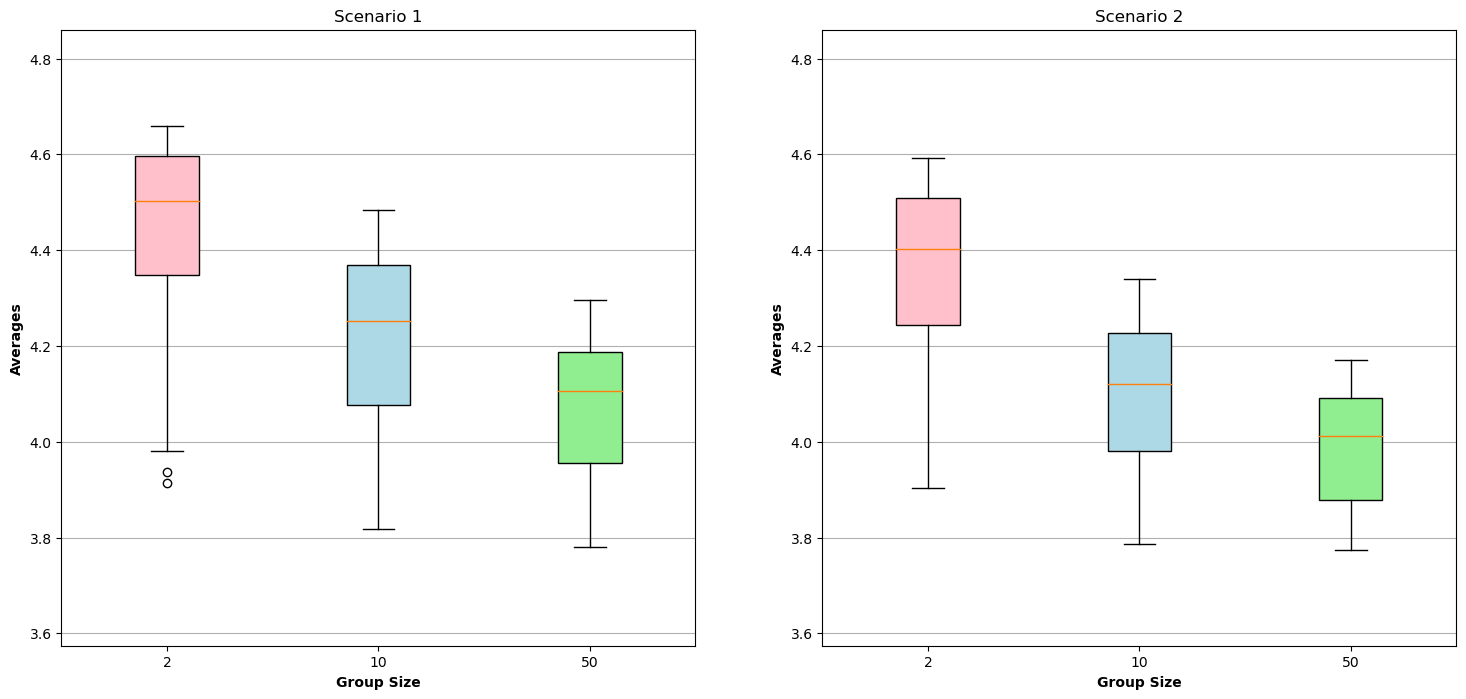

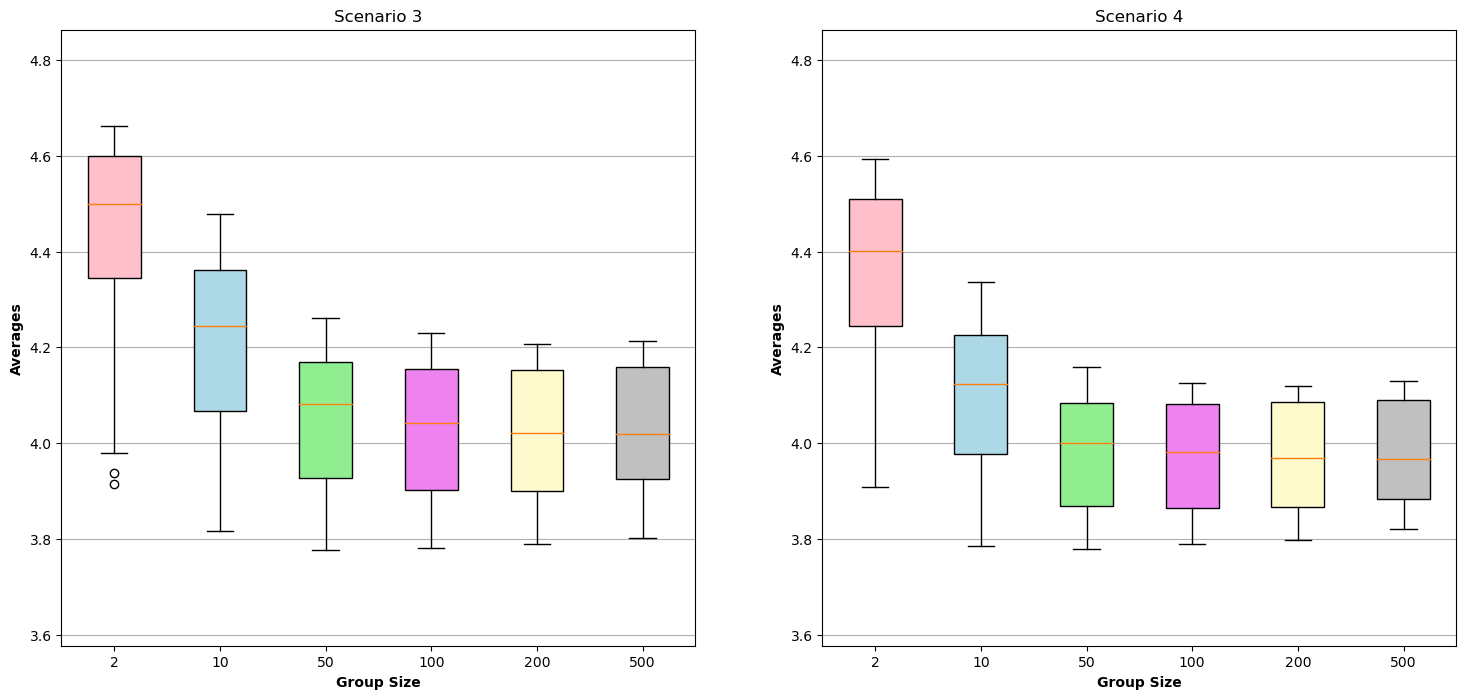

'\n######################\n## Scenario 5 and 6 ##\n\nScenario_5 = [group_mean[4][0], group_mean[4][4], group_mean[4][9], group_mean[4][13], group_mean[4][20], group_mean[4][22]]\nlabels = [\'2\', \'10\', \'50\', \'200\', \'2000\', \'5000\']\n\nScenario_6 = [group_mean[5][0], group_mean[5][4], group_mean[5][9], group_mean[5][13], group_mean[5][20], group_mean[5][22]]\nlabels = [\'2\', \'10\', \'50\', \'200\', \'2000\', \'5000\']\n\nfig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))\n\ntotal_min = min(group_min[4][0], group_min[4][4], group_min[4][9], group_min[4][13], group_min[4][20], group_min[4][22],\n                group_min[5][0], group_min[5][4], group_min[5][9], group_min[5][13], group_min[5][20], group_min[5][22])\ntotal_max = max(group_max[4][0], group_max[4][4], group_max[4][9], group_max[4][13], group_max[4][20], group_max[4][22],\n                group_max[5][0], group_max[5][4], group_max[5][9], group_max[5][13], group_max[5][20], group_max[5][22])\n\n\n# re

In [56]:
### Box Plots of Averages Between Scenarios and Group Sizes ###
cl_mean = []
cl_max = []
cl_min = []
group_mean = []
group_min = []
group_max = []

for s in range(0, 4):  # iterating on scenarios
     
    for i in range(0, len(cluster_list[s])): # iterariong on group sizes in each scenario
        data_1 = pd.DataFrame(Final_Rewards[s][0][i][:,1:].mean(axis = 0)) # the rewards of first group size in first p vector in each scenario

        for v in range(1, l): # iterating on 10 vectors of multiplyers
            data_1["{}".format(i)] = Final_Rewards[s][v][i][:,1:].mean()

        temp = data_1.mean(axis = 1) # Means of rows which ar the means of columns in each round
        cl_mean.append(temp) 
        cl_max.append(max(temp))
        cl_min.append(min(temp))
        
    group_mean.append(cl_mean)
    group_max.append(cl_max)
    group_min.append(cl_min)
    
    cl_mean = []
    cl_max = []
    cl_min = []

######################
## Scenario 1 and 2 ##

Scenario_1 = [group_mean[0][0], group_mean[0][3], group_mean[0][6]]
labels = ['2', '10', '50']

Scenario_2 = [group_mean[1][0], group_mean[1][3], group_mean[1][6]]
labels = ['2', '10', '50']

total_min = min(group_min[0][0], group_min[0][3], group_min[0][6], group_min[1][0], group_min[1][3], group_min[1][6])
total_max = max(group_max[0][0], group_max[0][3], group_max[0][6], group_max[1][0], group_max[1][3], group_max[1][6])


fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

# rectangular box plot
bplot1 = ax1.boxplot(Scenario_1,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_ylim(bottom = total_min - 0.2 , top = total_max + 0.2)
ax1.set_title('Scenario 1')

# rectangular box plot
bplot2 = ax2.boxplot(Scenario_2,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_ylim(bottom = total_min - 0.2 , top = total_max + 0.2)
ax2.set_title('Scenario 2')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_ylabel('Averages', fontweight="bold")
    ax.set_xlabel('Group Size', fontweight="bold")

plt.show()

######################
## Scenario 3 and 4 ##

Scenario_3 = [group_mean[2][0], group_mean[2][4], group_mean[2][8], group_mean[2][9], group_mean[2][11], group_mean[2][13]]
labels = ['2', '10', '50', '100', '200', '500']

Scenario_4 = [group_mean[3][0], group_mean[3][4], group_mean[3][8], group_mean[3][9], group_mean[3][11], group_mean[3][13]]
labels = ['2', '10', '50', '100', '200', '500']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

total_min = min(group_min[2][0], group_min[2][4], group_min[2][8], group_min[2][9], group_min[2][11], group_min[2][13],
                group_min[3][0], group_min[3][4], group_min[3][8], group_min[3][9], group_min[3][11], group_min[3][13])
total_max = max(group_max[2][0], group_max[2][4], group_max[2][8], group_max[2][9], group_max[2][11], group_max[2][13],
                group_max[3][0], group_max[3][4], group_max[3][8], group_max[3][9], group_max[3][11], group_max[3][13])


# rectangular box plot
bplot1 = ax1.boxplot(Scenario_3,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_ylim(bottom = total_min - 0.2 , top = total_max + 0.2)
ax1.set_title('Scenario 3')

# rectangular box plot
bplot2 = ax2.boxplot(Scenario_4,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_ylim(bottom = total_min - 0.2, top = total_max + 0.2)
ax2.set_title('Scenario 4')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen', 'violet', 'lemonchiffon', 'silver']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_ylabel('Averages', fontweight="bold")
    ax.set_xlabel('Group Size', fontweight="bold")

plt.show()

'''
######################
## Scenario 5 and 6 ##

Scenario_5 = [group_mean[4][0], group_mean[4][4], group_mean[4][9], group_mean[4][13], group_mean[4][20], group_mean[4][22]]
labels = ['2', '10', '50', '200', '2000', '5000']

Scenario_6 = [group_mean[5][0], group_mean[5][4], group_mean[5][9], group_mean[5][13], group_mean[5][20], group_mean[5][22]]
labels = ['2', '10', '50', '200', '2000', '5000']

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18, 8))

total_min = min(group_min[4][0], group_min[4][4], group_min[4][9], group_min[4][13], group_min[4][20], group_min[4][22],
                group_min[5][0], group_min[5][4], group_min[5][9], group_min[5][13], group_min[5][20], group_min[5][22])
total_max = max(group_max[4][0], group_max[4][4], group_max[4][9], group_max[4][13], group_max[4][20], group_max[4][22],
                group_max[5][0], group_max[5][4], group_max[5][9], group_max[5][13], group_max[5][20], group_max[5][22])


# rectangular box plot
bplot1 = ax1.boxplot(Scenario_5,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax1.set_ylim(bottom = total_min - 0.2, top = total_max + 0.2)
ax1.set_title('Scenario 5')

# rectangular box plot
bplot2 = ax2.boxplot(Scenario_6,
                     vert=True,  # vertical box alignment
                     patch_artist=True,  # fill with color
                     labels=labels)  # will be used to label x-ticks
ax2.set_ylim(bottom = total_min - 0.2 , top = total_max + 0.2)
ax2.set_title('Scenario 6')

# fill with colors
colors = ['pink', 'lightblue', 'lightgreen', 'violet', 'lemonchiffon', 'silver']
for bplot in (bplot1, bplot2):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)

# adding horizontal grid lines
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_ylabel('Averages', fontweight="bold")
    ax.set_xlabel('Group Size', fontweight="bold")

plt.show()
'''
